# LSTM

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import datetime # manipulating date formats

from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE, r2_score
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed


# settings
plt.style.use('seaborn-deep')

In [2]:
ts = pd.read_csv("cleaned-daily.csv", parse_dates = ['Date'])
ts = ts.set_index('Date')[["kWh"]].sort_index().asfreq('d')
ts.head(15)

,kWh
Date,
2017-01-01,399131.94
2017-01-02,545259.57
2017-01-03,557400.78
2017-01-04,557394.31
2017-01-05,554266.71
2017-01-06,484772.87
2017-01-07,448601.37
2017-01-08,433151.95
2017-01-09,638036.96


<AxesSubplot:xlabel='Date'>

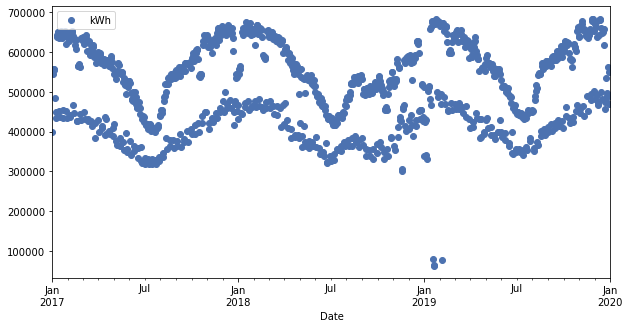

In [3]:
ts.plot(figsize=(10,5),style="o")

In [4]:
import holidays

begin = '2017-01-01'
end = '2019-12-31' # errors within the holidays package
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:end])

exo = ts.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.loc["2020-01-01","holidays"] = 1

ts["holidays"] = exo["holidays"]
ts

,kWh,holidays
Date,,
2017-01-01,399131.94,1
2017-01-02,545259.57,0
2017-01-03,557400.78,0
2017-01-04,557394.31,0
2017-01-05,554266.71,0
...,...,...
2019-12-28,490973.42,0
2019-12-29,470181.83,0
2019-12-30,550293.99,0


In [5]:
date = ts.index
timestamp_s = date.map(datetime.datetime.timestamp)

In [6]:
week = 7*24*60*60
ts['Week sin'] = np.sin(timestamp_s * (2 * np.pi / week))
ts['Week cos'] = np.cos(timestamp_s * (2 * np.pi / week))

Text(0.5, 1.0, 'Time of week signal')

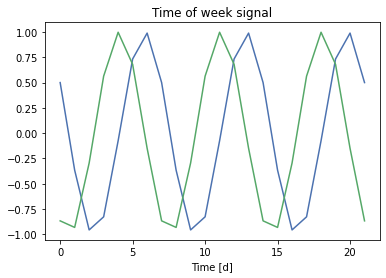

In [7]:
plt.plot(np.array(ts['Week sin'])[:22])
plt.plot(np.array(ts['Week cos'])[:22])

plt.xlabel('Time [d]')
plt.title('Time of week signal')

In [8]:
ts.head(10)

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,399131.94,1,0.500000,-0.866025
2017-01-02,545259.57,0,-0.365341,-0.930874
2017-01-03,557400.78,0,-0.955573,-0.294755
2017-01-04,557394.31,0,-0.826239,0.563320
2017-01-05,554266.71,0,-0.074730,0.997204
2017-01-06,484772.87,1,0.733052,0.680173
2017-01-07,448601.37,0,0.988831,-0.149042
2017-01-08,433151.95,0,0.500000,-0.866025
2017-01-09,638036.96,0,-0.365341,-0.930874


In [9]:
ts.describe()

,kWh,holidays,Week sin,Week cos
count,1096.000000,1096.000000,1096.000000,1096.000000
mean,513641.385976,0.028285,-0.001503,-0.001394
std,101693.964087,0.165861,0.707415,0.707442
min,61980.910000,0.000000,-0.955573,-0.943883
25%,434430.260000,0.000000,-0.826239,-0.846724
50%,519402.665000,0.000000,-0.111964,-0.111964
75%,597521.062500,0.000000,0.707107,0.680173
max,683808.340000,1.000000,0.993712,0.997204


In [10]:
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

test = ts[train_end:]
train_val = ts[:train_end]

n = len(train_val)

train = train_val[:int(n*0.8)]
vali = train_val[int(n*0.8):]


column_indices = {name: i for i, name in enumerate(ts.columns)}
num_features = ts.shape[1]
train

,kWh,holidays,Week sin,Week cos
Date,,,,
2017-01-01,399131.94,1,0.500000,-0.866025
2017-01-02,545259.57,0,-0.365341,-0.930874
2017-01-03,557400.78,0,-0.955573,-0.294755
2017-01-04,557394.31,0,-0.826239,0.563320
2017-01-05,554266.71,0,-0.074730,0.997204
...,...,...,...,...
2019-04-28,393050.09,0,0.532032,-0.846724
2019-04-29,570844.34,0,-0.330279,-0.943883
2019-04-30,551120.19,0,-0.943883,-0.330279


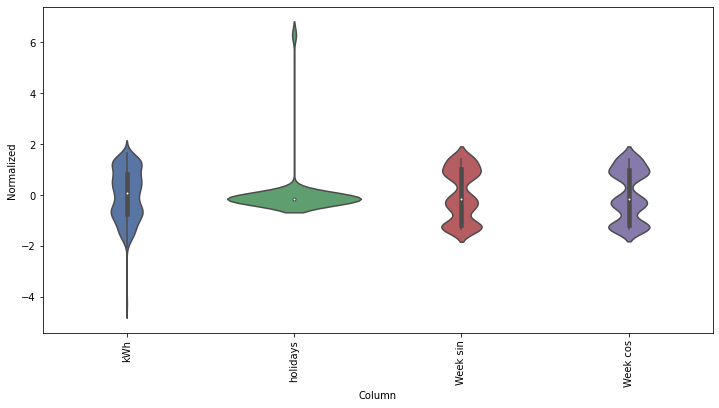

In [11]:
train_mean = train.mean()
train_std = train.std()

train = (train - train_mean) / train_std
vali = (vali - train_mean) / train_std
test = (test - train_mean) / train_std

ts_std = (ts - train_mean) / train_std
ts_std = ts_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=ts_std)
_ = ax.set_xticklabels(ts.keys(), rotation=90)

In [12]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train=train, vali=vali, test=test,
               label_columns=None):
        # Store the raw data.
        self.train = train
        self.vali = vali
        self.test = test

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift + label_width -1

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:, :, self.column_indices[name]] for name in self.label_columns],
                axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=self.total_window_size,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)
    


In [13]:
w1 = WindowGenerator(input_width=14, label_width=7, shift=1,
                     label_columns=['kWh'])
w1

Total window size: 21
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14 15 16 17 18 19 20]
Label column name(s): ['kWh']

In [14]:
example_window = tf.stack([np.array(train[:w1.total_window_size]),
                           np.array(train[100:100+w1.total_window_size]),
                           np.array(train[200:200+w1.total_window_size])])

example_inputs, example_labels = w1.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 21, 4)
Inputs shape: (3, 14, 4)
labels shape: (3, 7, 1)


In [15]:
example_inputs

<tf.Tensor: shape=(3, 14, 4), dtype=float64, numpy=
array([[[-1.09226265,  6.28688979,  0.71000316, -1.22226075],
        [ 0.31878607, -0.15887447, -0.51380843, -1.31386042],
        [ 0.43602494, -0.15887447, -1.34854581, -0.41532932],
        [ 0.43596246, -0.15887447, -1.1656347 ,  0.79672032],
        [ 0.40576149, -0.15887447, -0.1028109 ,  1.40959039],
        [-0.2652902 ,  6.28688979,  1.03959759,  0.96177723],
        [-0.61457219, -0.15887447,  1.40133388, -0.20950671],
        [-0.76375605, -0.15887447,  0.71000316, -1.22226075],
        [ 1.21467014, -0.15887447, -0.51380843, -1.31386042],
        [ 1.26816079, -0.15887447, -1.34854581, -0.41532932],
        [ 1.33592014, -0.15887447, -1.1656347 ,  0.79672032],
        [ 1.34215104, -0.15887447, -0.1028109 ,  1.40959039],
        [ 1.17941363, -0.15887447,  1.03959759,  0.96177723],
        [-0.58439961, -0.15887447,  1.40133388, -0.20950671]],

       [[ 0.58210614, -0.15887447, -1.33201393, -0.46550757],
        [ 0.6835

In [16]:
def plot(self, model=None, plot_col='kWh', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
        plt.subplot(3, 1, n+1)
        plt.ylabel(f'{plot_col} [normed]')
        plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                 label='Inputs', marker='.', zorder=-10)

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        if label_col_index is None:
            continue

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)
        if model is not None:
            predictions = model(inputs)
            plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

        if n == 0:
            plt.legend()

    plt.xlabel('Time [d]')

WindowGenerator.plot = plot

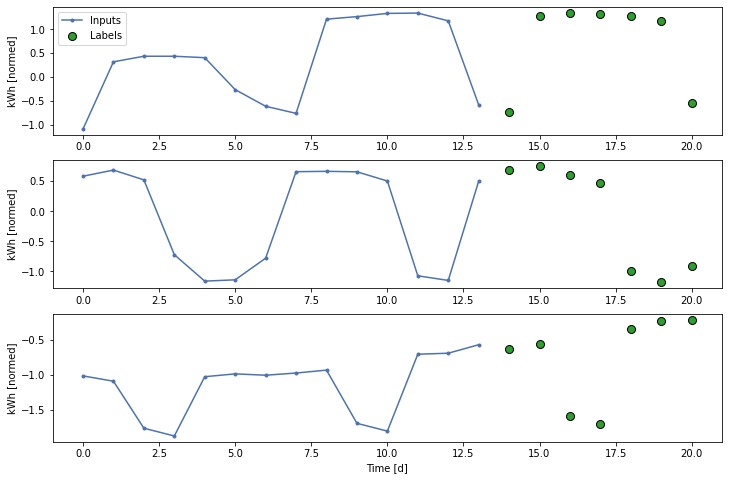

In [17]:
w1.example = example_inputs, example_labels
w1.plot()


In [18]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds

WindowGenerator.make_dataset = make_dataset

In [19]:
@property
def train(self):
    return self.make_dataset(self.train)

@property
def val(self):
    return self.make_dataset(self.vali)

@property
def test(self):
    return self.make_dataset(self.test)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [ ]:
# Each element is an (inputs, label) pair
w1.train.element_spec

In [ ]:
w1

In [ ]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')